# Task 1
Load the data file and explore the data, showing size, data descriptions, data distributions with boxplot, pairplots

Comment the exploration of this step pointing out if
- there are imbalanced distributions
- outliers
- missing values
- non–numeric fields with number of distinct values similar to the number of records

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_path = "data.csv"

df = pd.read_csv(dataset_path)
print(f"the dataset has {df.shape[0]} rows and {df.shape[1]} columns")
df.sample(5)

the dataset has 1484 rows and 9 columns


,V0,V1,V2,V3,V4,V5,V6,V7,V8
1288,TRK2_YEAST,0.59,0.48,0.41,0.53,0.5,0.0,0.48,0.56
87,BAR1_YEAST,0.80,0.63,0.45,0.29,0.5,0.0,0.51,0.22
28,KAD2_YEAST,0.63,0.67,0.57,0.24,0.5,0.0,0.49,0.22
989,RL41_YEAST,0.35,0.21,1.00,0.80,0.5,0.0,0.13,0.01
1138,SPA2_YEAST,0.50,0.45,0.51,0.19,0.5,0.0,0.53,0.25


Looking at the data description it's clear that there are no missing values since the _count_ of every feature is equal to the number of rows (1484)

We can also notice that the feature "_V0_" is the only categorical field (nominal) and it does indeed have a number of unique values similar to the number of records. Thus, it seems that _V0_ is a feature that **needs to be eliminated** before clustering because it can't describe similarity between datapoints since almost every value is basically unique.

If i were to transform V0 to a numeric type using something like a _LabelEncoder()_, i would be introducing "fake" distances between the datapoints and the resulting clustering scheme would suffer because of it.

In [3]:
df.describe(include="all")

,V0,V1,V2,V3,V4,V5,V6,V7,V8
count,1484,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
unique,1462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,RL41_YEAST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,NaN,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,NaN,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,NaN,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,NaN,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,NaN,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000


Looking at the box plot of the features we can notice a few things:
- the values of all the features reside all in the range [0,1];
    - no need for normalizing scales, every feature contributes in an equal way to the distance between datapoints 
- almost every feature has a lot of outliers apart from *V5* and *V6*
    - All these outliers are a problem for a clustering schemes based on distances. For example, in kmeans, because their values are so different from the rest of the datapoints, outliers shift the position of the centroids and resulting clusters tend to be less compact because of it.
- the distributions of V1, V2, V3 and V7 are quite balanced
- the distributions of V4 and V8 are quite unbalanced and tend towards the left
    - clustering is more effective when features are balanced so V4 e V8 need to be made for gaussian with something like a PowerTransformer() 
- the distributions of V5 and V6 are concentrated in a single value (respectively 0.5 and 0.0) apart from a few outliers. There is almost no variance

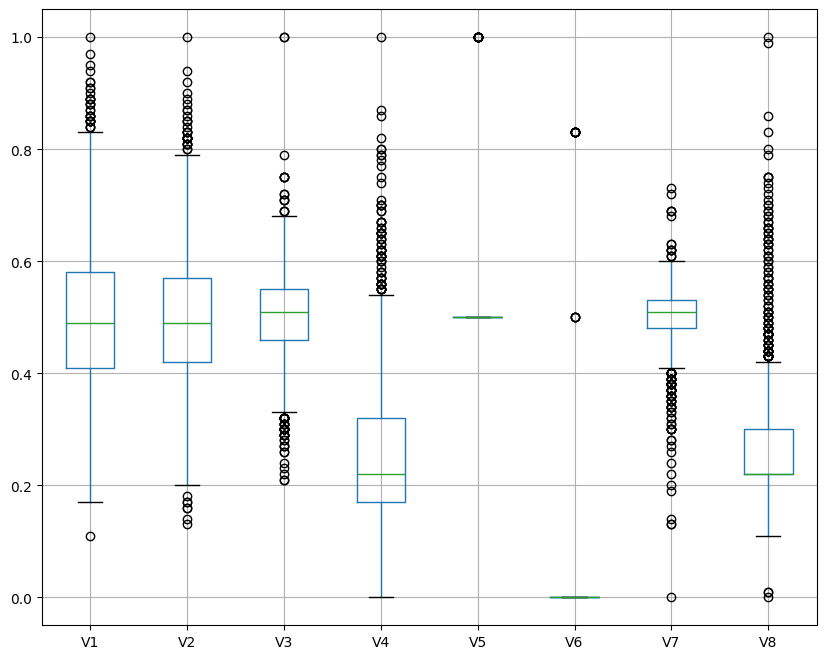

In [4]:
plt.figure(figsize=(10, 8))
df.boxplot()
plt.show()

Looking at the pairplot we notice mostly the same things as above.

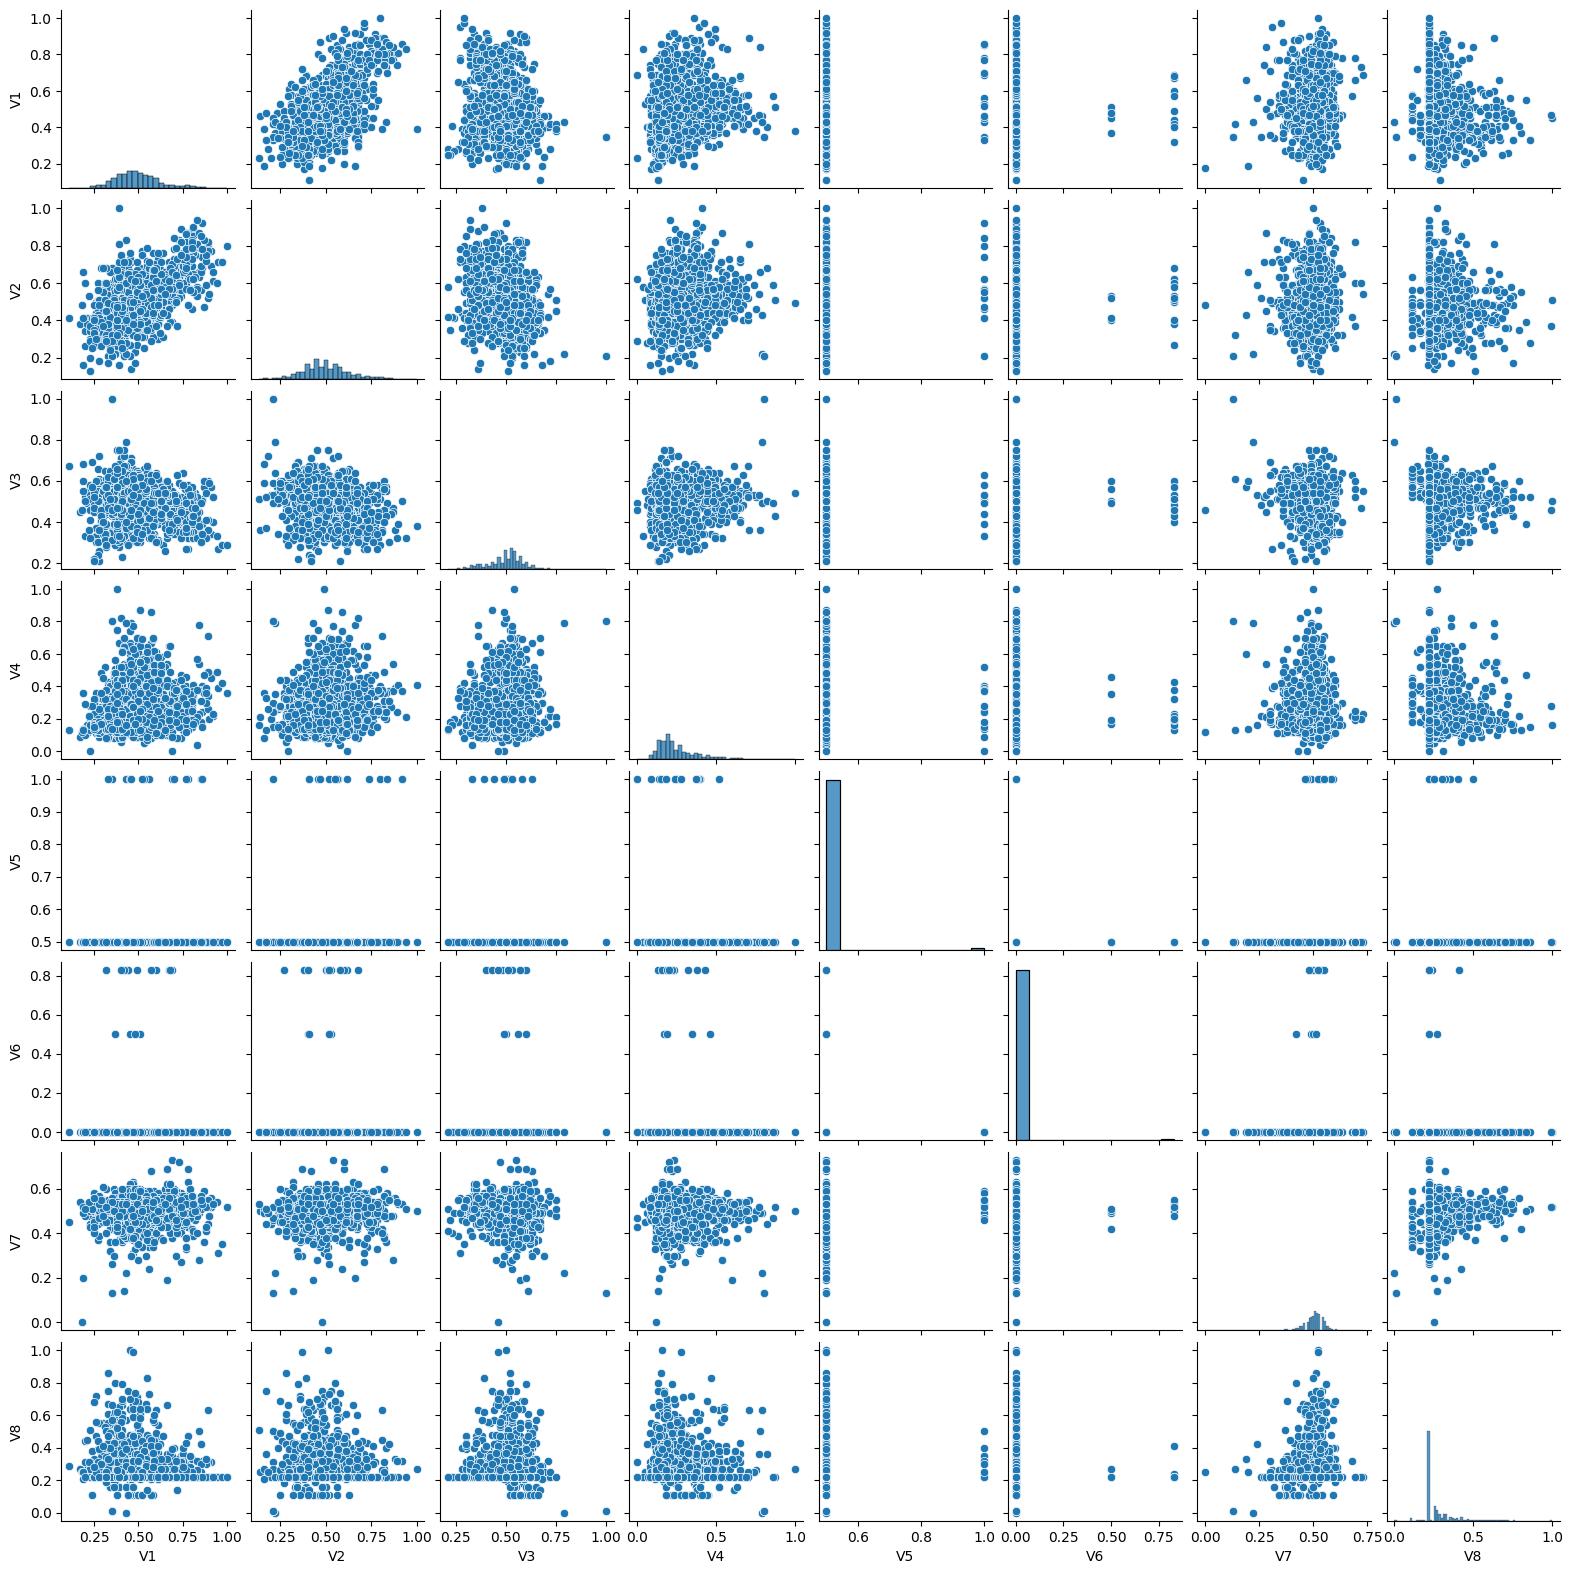

In [14]:
sns.pairplot(df, height=2)
plt.show()

# Task 3
Drop the columns that are not relevant for the clustering operation, if any, and explain why you do that. Deal with missing values, if any 

There are no missing values to deal with, if there were i would first see if just dropping the rows with null values was a possible solution. If dropping the rows reduced the size of the dataset too much, i would use imputing with the mean/median as an alternative strategy

for the reasons explained above V0 has to be dropped.

V5 and V6 also have to be dropped since they are almosto constant across the dataset and thus they cannot separate datapoints

In [5]:
df2 = df.copy()
df2 = df.drop(["V0", "V5", "V6"], axis=1)
df2

,V1,V2,V3,V4,V7,V8
0,0.58,0.61,0.47,0.13,0.48,0.22
1,0.43,0.67,0.48,0.27,0.53,0.22
2,0.64,0.62,0.49,0.15,0.53,0.22
3,0.58,0.44,0.57,0.13,0.54,0.22
4,0.42,0.44,0.48,0.54,0.48,0.22
...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.53,0.22
1480,0.47,0.43,0.61,0.40,0.48,0.47
1481,0.67,0.57,0.36,0.19,0.56,0.22
1482,0.43,0.40,0.60,0.16,0.53,0.39


Per ridurre l'effetto degli outlier e per rendere più Gaussian-like V4 e V8 facciamo una data transformation con  PowerTransformer()

Successivamente, facciamo anche uno scaling per riportare le feature nel range [0,1] dopo la trasformazione

In [6]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

df3 = df2.copy()

pt = PowerTransformer()
scaler = MinMaxScaler(feature_range=(0, 1))

df3 = pd.DataFrame(pt.fit_transform(df3), columns=df3.columns)
display(df3.sample(5))

df3 = pd.DataFrame(scaler.fit_transform(df3), columns=df3.columns)
df3.sample(5)

,V1,V2,V3,V4,V7,V8
1067,0.386070,-0.442437,-1.687938,-0.427177,0.086843,0.184313
697,-1.741636,-1.350677,0.562159,0.100513,0.086843,-0.542979
789,1.777319,1.745559,0.090023,0.364794,-2.380296,-0.542979
337,-0.054039,-1.255502,-0.931921,-0.201584,1.417716,-0.542979
151,-0.369483,-0.884755,0.324715,-1.092945,0.715740,1.649073


,V1,V2,V3,V4,V7,V8
420,0.627895,0.562293,0.351987,0.531712,0.353814,0.842725
945,0.638380,0.606768,0.376411,0.551121,0.371115,0.681562
281,0.852185,0.740695,0.112710,0.635755,0.427083,0.681562
1069,0.489495,0.405311,0.388728,0.531712,0.489600,0.681562
1418,0.476803,0.405311,0.245589,0.793896,0.427083,0.724354


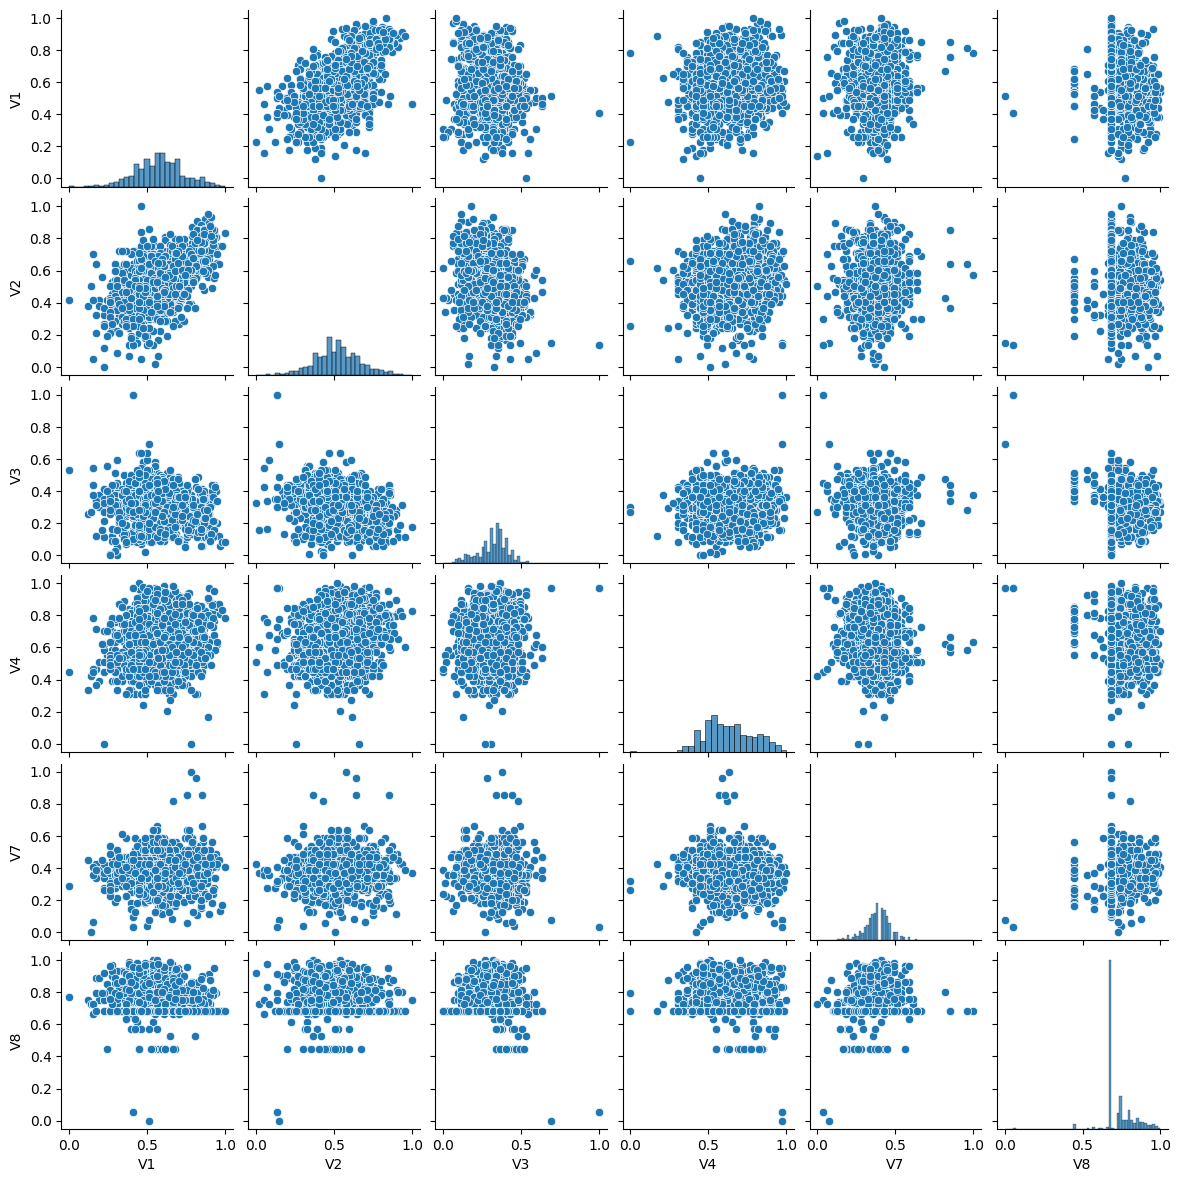

In [45]:
sns.pairplot(df3, height=2)

In [7]:
# boh, provo anche ad eliminare direttamente le feature con distribuzione skewed
df4 = df2.copy()
df4 = df2.drop(["V4", "V8"], axis=1)
df4

,V1,V2,V3,V7
0,0.58,0.61,0.47,0.48
1,0.43,0.67,0.48,0.53
2,0.64,0.62,0.49,0.53
3,0.58,0.44,0.57,0.54
4,0.42,0.44,0.48,0.48
...,...,...,...,...
1479,0.81,0.62,0.43,0.53
1480,0.47,0.43,0.61,0.48
1481,0.67,0.57,0.36,0.56
1482,0.43,0.40,0.60,0.53


<Axes: >

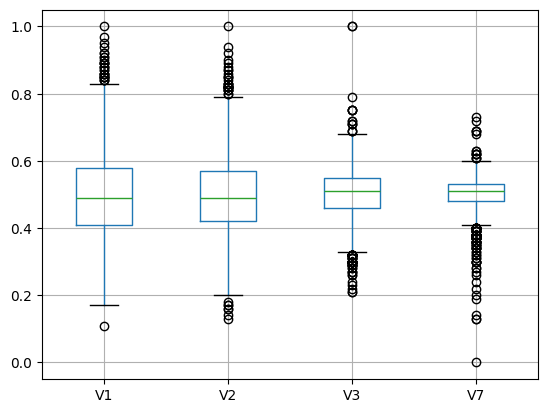

In [8]:
df4.boxplot()

# Task 4
 
find the best clustering scheme with KMeans
- require not less than 3 clusters
- show the hyperparameters
- show the silhouette plots of clusters
- show the distribution of the resulting cluster labels (e.g. histogram or pie plot)

In [11]:
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score, silhouette_samples

param_grid = ParameterGrid({
    "n_clusters": range(3,11)
})

list(param_grid)    

[{'n_clusters': 3},
 {'n_clusters': 4},
 {'n_clusters': 5},
 {'n_clusters': 6},
 {'n_clusters': 7},
 {'n_clusters': 8},
 {'n_clusters': 9},
 {'n_clusters': 10}]

In [12]:
results = pd.DataFrame(columns=["labels", "n_clusters", "silhouette", "inertia"])

for p in param_grid:
    km = KMeans(**p)
    labels = km.fit_predict(df4)
    results.loc[len(results)] = [labels, p["n_clusters"], silhouette_score(df4, labels), km.inertia_]

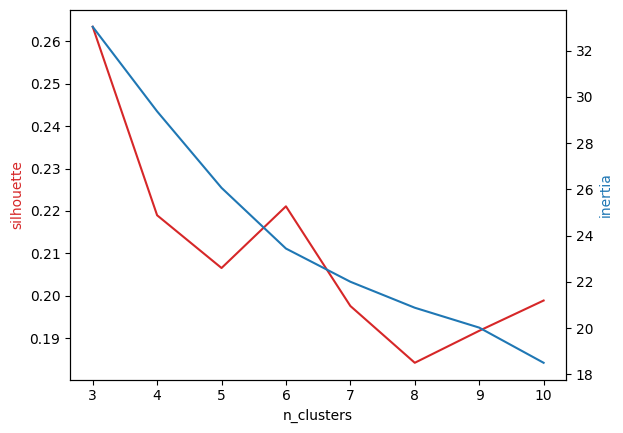

In [13]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("n_clusters")
ax1.set_ylabel("silhouette", color="tab:red" )
ax1.plot(results["n_clusters"], results["silhouette"], color="tab:red")

ax2 = ax1.twinx()

ax2.set_xlabel("n_clusters")
ax2.set_ylabel("inertia", color="tab:blue" )
ax2.plot(results["n_clusters"], results["inertia"], color="tab:blue")

In [14]:
results.sort_values(by=["silhouette", "inertia"], ascending=[False, True])

,labels,n_clusters,silhouette,inertia
0,"[1, 1, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",3,0.263466,33.027639
3,"[5, 0, 5, 4, 1, 4, 0, 4, 4, 3, 3, 3, 3, 4, 5, ...",6,0.221090,23.441195
1,"[2, 2, 2, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, ...",4,0.218978,29.371133
2,"[3, 3, 3, 0, 4, 0, 3, 0, 0, 1, 1, 1, 1, 0, 3, ...",5,0.206530,26.065079
7,"[0, 2, 7, 6, 1, 6, 9, 6, 0, 5, 6, 5, 1, 6, 7, ...",10,0.198857,18.502944
4,"[1, 5, 1, 6, 2, 6, 5, 2, 6, 2, 2, 2, 2, 6, 1, ...",7,0.197569,22.005962
6,"[0, 6, 0, 4, 1, 1, 6, 1, 4, 1, 1, 1, 1, 4, 0, ...",9,0.191711,20.023121
5,"[5, 6, 5, 1, 0, 0, 6, 0, 1, 0, 0, 7, 0, 1, 5, ...",8,0.184164,20.882842


In [15]:
# il miglior schema di clustering per kmeans sembra essere quello  n_clusters = 3
# Anche n_clusters = 4 sembra un'alternativa ...
# ...
# Ho deciso di scegliere comunque n_clusters = 3 dato che parte della riduzione dell'inerzia ...

best_clustering = results.loc[0]
best_clustering

labels        [1, 1, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...
n_clusters                                                    3
silhouette                                             0.263466
inertia                                               33.027639
Name: 0, dtype: object

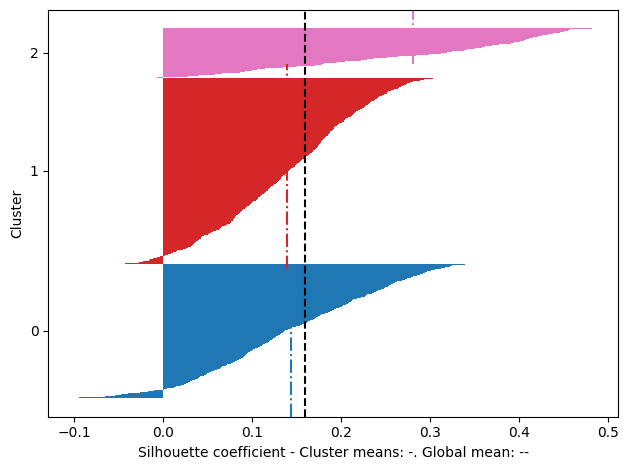

In [16]:
import plot_silhouette_w_mean

# visualizziamo i silhouette plots
labels = best_clustering["labels"]
silhouette_vals = silhouette_samples(df2, labels)

plot_silhouette_w_mean.plot_silhouette(silhouette_vals, labels)

Text(0.5, 1.0, 'distribuzione dei cluster in k-means')

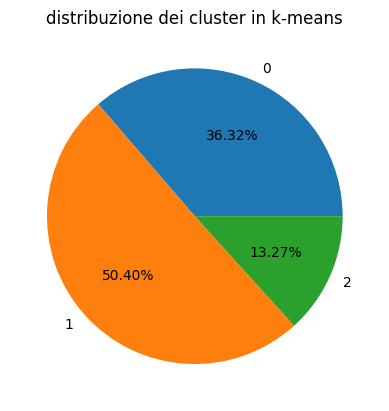

In [17]:
import numpy as np

km_distribution = np.unique(labels, return_counts=True)
plt.pie(
    km_distribution[1],
    labels = km_distribution[0],
    autopct="%.2f%%"
)
plt.title("distribuzione dei cluster in k-means")

# Task 5
find the best clustering scheme with Agglomerative Clustering or DBSCAN (your choice)
- require not less than 3 clusters
- show the hyperparameters
- show the silhouette plots of clusters
- show the distribution of the resulting cluster labels (e.g. histogram or pie plot)

In [18]:
param_grid = ParameterGrid({
    "n_clusters": range(3,11),
    "linkage": ["ward", "complete", "average", "single"]
})

list(param_grid)    

[{'linkage': 'ward', 'n_clusters': 3},
 {'linkage': 'ward', 'n_clusters': 4},
 {'linkage': 'ward', 'n_clusters': 5},
 {'linkage': 'ward', 'n_clusters': 6},
 {'linkage': 'ward', 'n_clusters': 7},
 {'linkage': 'ward', 'n_clusters': 8},
 {'linkage': 'ward', 'n_clusters': 9},
 {'linkage': 'ward', 'n_clusters': 10},
 {'linkage': 'complete', 'n_clusters': 3},
 {'linkage': 'complete', 'n_clusters': 4},
 {'linkage': 'complete', 'n_clusters': 5},
 {'linkage': 'complete', 'n_clusters': 6},
 {'linkage': 'complete', 'n_clusters': 7},
 {'linkage': 'complete', 'n_clusters': 8},
 {'linkage': 'complete', 'n_clusters': 9},
 {'linkage': 'complete', 'n_clusters': 10},
 {'linkage': 'average', 'n_clusters': 3},
 {'linkage': 'average', 'n_clusters': 4},
 {'linkage': 'average', 'n_clusters': 5},
 {'linkage': 'average', 'n_clusters': 6},
 {'linkage': 'average', 'n_clusters': 7},
 {'linkage': 'average', 'n_clusters': 8},
 {'linkage': 'average', 'n_clusters': 9},
 {'linkage': 'average', 'n_clusters': 10},
 {'li

In [24]:
from sklearn.cluster import AgglomerativeClustering
results_agg = pd.DataFrame(columns=["labels", "n_clusters", "silhouette", "linkage"])

for p in param_grid:
    agg = AgglomerativeClustering(**p)
    labels = agg.fit_predict(df4)
    results_agg.loc[len(results_agg)] = [labels, p["n_clusters"], silhouette_score(df4, labels), p["linkage"]]

In [25]:
results_agg.sort_values("silhouette", ascending=False)

,labels,n_clusters,silhouette,linkage
16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,0.528027,average
25,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0.471523,single
24,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,0.469706,single
26,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,0.431887,single
17,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0.407980,average
18,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",5,0.404281,average
27,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,0.396174,single
28,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,0.365367,single
19,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",6,0.339806,average
29,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,0.303908,single


In [26]:
best_clustering_agg = results_agg.loc[24]
np.unique(best_clustering_agg["labels"], return_counts=True)

(array([0, 1, 2]), array([1482,    1,    1]))

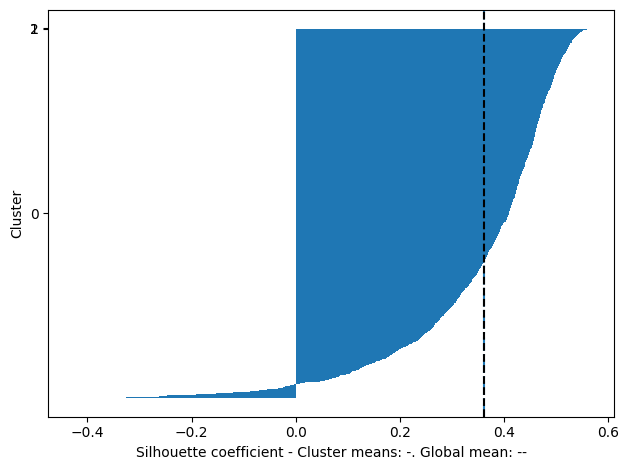

In [27]:
# visualizziamo i silhouette plots
labels = best_clustering_agg["labels"]
silhouette_vals = silhouette_samples(df3, labels)

plot_silhouette_w_mean.plot_silhouette(silhouette_vals, labels)

Text(0.5, 1.0, 'distribuzione dei cluster in agglomerative clustering')

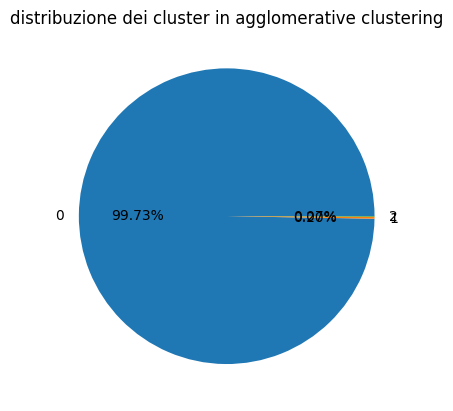

In [219]:
agg_distribution = np.unique(labels, return_counts=True)
plt.pie(
    agg_distribution[1],
    labels = agg_distribution[0],
    autopct="%.2f%%"
)
plt.title("distribuzione dei cluster in agglomerative clustering")

wtf is going on??? 

mi sa che tutto finisce in un unico cluster a causa degli outlier

questi, continuo ad immaginare, rimangono nel cluster 2 e nel cluster 3 mentre tutti gli altri punti vengono inglobati tutti nel cluster 0 dato che, seppur non simili (vicini) tra di loro, sono comunque più simili rispetto agli outlier

# Task 6 (per mia curiosità)

fai anche con DBSCAN

In [194]:
param_grid = ParameterGrid({
    "eps": np.arange(0.1, 1, 0.01),
    "min_samples": range(3,11)
})

# list(param_grid)    

In [195]:
from sklearn.cluster import DBSCAN
results_db = pd.DataFrame(columns=["labels", "n_clusters", "silhouette", "eps", "min_samples", "unclust%"])

tot = len(df3)
for p in param_grid:
    db = DBSCAN(**p)
    labels = db.fit_predict(df3)

    unclust_percentage = len(labels[labels != -1]) / tot
    
    if len(np.unique(labels[labels!=-1])) > 2:
        results_db.loc[len(results_db)] = [labels, len(np.unique(labels)), silhouette_score(df3, labels), p["eps"], p["min_samples"], unclust_percentage]
        

In [196]:
results_db.sort_values("silhouette", ascending=False)

,labels,n_clusters,silhouette,eps,min_samples,unclust%
24,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0.144826,0.18,3,0.968329
22,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0.135145,0.17,3,0.958221
19,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,0.047783,0.16,3,0.945418
16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0.030000,0.14,4,0.873315
23,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,0.021343,0.17,6,0.940701
20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,0.014767,0.16,4,0.938005
18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,0.013128,0.15,4,0.902965
17,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,-0.025595,0.15,3,0.917790
21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,-0.045971,0.16,5,0.932615
15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,-0.047983,0.14,3,0.889488


In [199]:
best_clustering_db = results_db.loc[24]
np.unique(best_clustering_db["labels"], return_counts=True)

(array([-1,  0,  1,  2]), array([  47, 1417,   17,    3]))

boh